# **Text Mining and Analysis with Twitter Data**

**Joshua Peterson**
***

**Goal of Project:** Detecting and Determining the Intentionality of COVID-19 Misinformation on Social Media

<br>

**Brief Overview of Project:** The purpose of this research project is to develop models and methods that are able to detect misinformation on social media platforms. Additionally, methods for determining the intent of that misinformation are explored so the maliciousness and severity of the detected misinformation can be better understood.

<br>

***Before this goal can be addressed, we must gain an understanding of the tweet dataset using text mining and analysis methods.***

## **Set Up Environment**

In [1]:
# Utilities
import os
import pandas as pd
import numpy as np

# Ignore future warnings
import warnings
warnings.filterwarnings('ignore')

Mount Google Drive and set working directory.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/MyDrive/DSBA Research Project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/19gmbQNBnP5zBu_ZfjIKfb98YxZIGkrp8/Machine Learning Project


## **Load Dataset**

In [3]:
# load tweet data from working directory
tweetdf = pd.read_csv('data/final_twitter_data.csv')
tweetdf.head()

,id,date,tweet,username,lang,replyCount,likeCount,retweetCount,tweet_class
0,1.265080e+18,2020-05-26 00:56:04+00:00,"Ian Haydon, who is participating in a vaccine ...",AC360,en,22,193,63,fake news
1,1.252420e+18,2020-04-21 02:16:11+00:00,Gachibowli Sports Tower turns Covid hospital\n...,BRSparty,en,11,409,46,fake news
2,1.253760e+18,2020-04-24 19:04:33+00:00,"Protesters at state Capitol are chanting ""Wher...",sbauerAP,en,21,567,192,fake news
3,1.237780e+18,2020-03-11 16:26:53+00:00,"🚨 BREAKING 🚨\n\n""We have therefore made the as...",WHO,en,1972,51420,50128,ambiguous
4,1.270080e+18,2020-06-08 19:53:19+00:00,1/2\n\n@WHO recently published a summary of tr...,mvankerkhove,en,100,606,283,fake news


In [4]:
# convert tweet class
tweetdf['tweet_class'] = tweetdf['tweet_class'].replace({'fake news': 'misinformation', 'true news': 'informational'})

In [5]:
# keep only relevent columns
tweetdf = tweetdf[['tweet', 'tweet_class']]
tweetdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17679 entries, 0 to 17678
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet        17679 non-null  object
 1   tweet_class  16881 non-null  object
dtypes: object(2)
memory usage: 276.4+ KB


In [6]:
# drop tweets without a label/class
tweetdf = tweetdf.dropna()
tweetdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16881 entries, 0 to 17678
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet        16881 non-null  object
 1   tweet_class  16881 non-null  object
dtypes: object(2)
memory usage: 395.6+ KB


What classes are present in the dataset?

In [7]:
tweetdf.tweet_class.value_counts()

,count
tweet_class,
informational,9004
misinformation,7395
political,378
ambiguous,104


The "political" and "ambiguous" classes are underrepresented and not relevent to the goal of the project. Therefore, those classes will be removed.

In [8]:
# drop the political and ambiguous classes as they are not well represented in the tweetdf dataset
dropindex = tweetdf[tweetdf['tweet_class'].isin(['political', 'ambiguous'])].index
tweetdf = tweetdf.drop(dropindex)
tweetdf.tweet_class.value_counts()

,count
tweet_class,
informational,9004
misinformation,7395


## **Text Preprocessing**

Preview of preprocessed tweets so we can start to understand what the contents of the tweets look like.

In [9]:
# preview sample of raw tweets
with pd.option_context('display.max_colwidth', 1):
    display(tweetdf['tweet'][0:5])

,tweet
0,"Ian Haydon, who is participating in a vaccine trial for coronavirus, says he feels “totally normal” after taking both doses of the vaccine but that his initial side effects from the highest dose included fever and nausea. https://t.co/q6kNQxa8xF"
1,Gachibowli Sports Tower turns Covid hospital\n\nThe 14-storyed Sports Tower at the Gachibowli Stadium was left unused for more than a decade. Having been constructed in 2007 for the World Military Games....https://t.co/7UBjVQmrql\n@TelanganaToday\n#TelanganaFightsCorona https://t.co/hSQJ1Vx6Dw
2,"Protesters at state Capitol are chanting ""Where's our flag?"" and pointing to the Capitol, saying it's a ""disgrace"" there is no flag\n\nThe American flag flies on the other side of the building from where they are rallying"
4,"1/2\n\n@WHO recently published a summary of transmission of #COVID19, incl. symptomatic, pre-symptomatic and asymptomatic transmission\n\nSee page 2 of👇\nhttps://t.co/2OJ2pLT5Iu\n\nIn this summary, we state: ""Comprehensive studies..."
5,"2/2 ... on transmission from asymptomatic individuals are difficult to conduct, but the available evidence from contact tracing reported by Member States suggests that asymptomatically-infected individuals are much less likely to transmit the virus than those who develop symptoms"


The following is a function to clean tweet text. Regular expressions are used to identify patterns to be removed when cleaning tweet text.
<br>For more info on regular expression operations, see the following link:

https://docs.python.org/3/library/re.html

In [10]:
import re

def clean_text(text):
    pat1 = r'@[^ ]+' # [^ ]+
    pat2 = r'https?://[A-Za-z0-9./]+'
    pat3 = r'\'s'
    pat4 = r'\#\w+'
    pat5 = r'&amp '
    pat6 = r'[^A-Za-z\s]'
    pat7 = r'\n'
    combined_pat = r'|'.join((pat1, pat2, pat3, pat4, pat5, pat6, pat7)) # combines created regex patterns set above
    text = re.sub(combined_pat, ' ', text) # removes those regex patterns from text passed through the function
    text = re.sub(' +', ' ', text) # removes unwanted whitespace within cleaned tweet
    return text.strip() # returns the text and strips leading and trailing whitespace

Now the tweets are cleaned using the defined `clean_text` function.

In [11]:
# apply/map the 'clean_text' function to the 'tweet' column to clean the tweet text data
tweetdf['cleaned_tweet'] = tweetdf['tweet'].apply(clean_text)

with pd.option_context('display.max_colwidth', 1):
    display(tweetdf['cleaned_tweet'][0:5])

,cleaned_tweet
0,Ian Haydon who is participating in a vaccine trial for coronavirus says he feels totally normal after taking both doses of the vaccine but that his initial side effects from the highest dose included fever and nausea
1,Gachibowli Sports Tower turns Covid hospital The storyed Sports Tower at the Gachibowli Stadium was left unused for more than a decade Having been constructed in for the World Military Games
2,Protesters at state Capitol are chanting Where our flag and pointing to the Capitol saying it a disgrace there is no flag The American flag flies on the other side of the building from where they are rallying
4,recently published a summary of transmission of incl symptomatic pre symptomatic and asymptomatic transmission See page of In this summary we state Comprehensive studies
5,on transmission from asymptomatic individuals are difficult to conduct but the available evidence from contact tracing reported by Member States suggests that asymptomatically infected individuals are much less likely to transmit the virus than those who develop symptoms


Next, we will make the tweets all lowercase, remove stop words and apply lemmatization

**Lemmatization:** caring, cared, cares ➡ care


In [18]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize

nltk.download('stopwords') # download the english stopwords dictionary
nltk.download('wordnet') # download the wordnet dictionary for lemmatization
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Map POS tag to first character for WordNetLemmatizer
def get_wordnet_pos(word):
    from nltk import pos_tag

    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_tweet(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    new_stop = ['via'] # identify any additional stop words to be considered
    all_stop = stop_words.union(new_stop) # add those new stopwords to the already defined list of stop words

    # Convert to lowercase and tokenize
    words = word_tokenize(text.lower())

    # Lemmatize, remove stopwords, and rejoin words
    lemmatized_words = [
        lemmatizer.lemmatize(w, get_wordnet_pos(w))
        for w in words if w.isalpha() and w not in stop_words
    ]
    return ' '.join(lemmatized_words)

tweetdf['processed_tweet'] = tweetdf['cleaned_tweet'].apply(lemmatize_tweet)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


What do the tweets look like now?



In [19]:
with pd.option_context('display.max_colwidth', 1):
    display(tweetdf['processed_tweet'][0:5])

,processed_tweet
0,ian haydon participate vaccine trial coronavirus say feel totally normal take dos vaccine initial side effect high dose include fever nausea
1,gachibowli sport tower turn covid hospital storyed sport tower gachibowli stadium left unused decade construct world military game
2,protester state capitol chant flag point capitol say disgrace flag american flag fly side building rally
4,recently publish summary transmission incl symptomatic pre symptomatic asymptomatic transmission see page summary state comprehensive study
5,transmission asymptomatic individual difficult conduct available evidence contact trace report member state suggests asymptomatically infect individual much less likely transmit virus develop symptom


**Term Frequencies**

What are the most frequent unigrams across all the tweets?

In [20]:
from collections import Counter
from itertools import chain

counter = Counter(chain.from_iterable(map(str.split, tweetdf.processed_tweet.to_list())))

counts = pd.Series(counter).sort_values(ascending=False)

counts[:20]

,0
coronavirus,7117
covid,6303
vaccine,1642
new,1351
virus,1334
test,1324
show,1281
people,1195
health,1108
patient,1070


What are the most frequent bigrams across all the tweets?

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

bivectorizer = CountVectorizer(ngram_range=(2,2), analyzer='word') # # initiate vectorizer to be used on tweet text for bigrams
bigram_vectorized = bivectorizer.fit_transform(tweetdf["processed_tweet"]) # fit and transform the processed tweet data using the bigram vectorizer

frequencies = sum(bigram_vectorized).toarray()[0] # calculate the frequecies of the bigrams

counts = pd.Series(frequencies, index=bivectorizer.get_feature_names_out()).sort_values(ascending=False)

counts[:20]

,0
covid vaccine,797
test positive,529
new coronavirus,498
positive coronavirus,470
vaccine candidate,447
coronavirus outbreak,422
show promise,406
candidate show,397
stable hour,373
immune system,368


## **Mining and Analysis of Tweets**

In [22]:
import seaborn as sns

# set theme for future seaborn plots
sns.set_theme()
sns.set_style("ticks")

# color palette dictionary to be used for future plots
pal = {"misinformation": "#A49665",
       "ambiguous": "#802F2D",
       "informational": "#005035",
       "political": "#007377"}

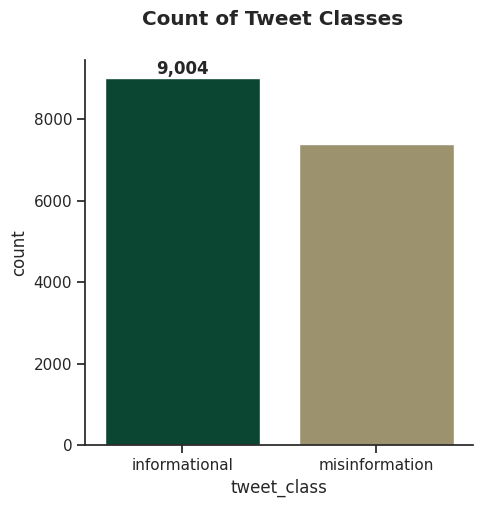

In [47]:
import matplotlib.pyplot as plt

# plotting the distribution of tweet classes.
fig, ax = plt.subplots(1, figsize=(5,5)) # set number of plots and the size of figure

p = sns.countplot(x=tweetdf['tweet_class'], palette=pal, order=tweetdf['tweet_class'].value_counts().index) # create countplot of 'tweet_class' column values
pcount = p.containers[0] # get count of classes to be shown on plot
p.bar_label(pcount, labels=[f'{x:,.0f}' for x in pcount.datavalues], fontsize='12', fontweight='bold') # add count labels to countplot
fig.suptitle("Count of Tweet Classes", fontweight='bold')

sns.despine()
plt.show()

### Word Clouds

In [26]:
truenewsdf = tweetdf.loc[(tweetdf['tweet_class'] == "informational")] # create dataset of only tweets labeled as 'true news'
fakenewsdf = tweetdf.loc[(tweetdf['tweet_class'] == "misinformation")] # create dataset of only tweets labeled as 'fake news'

Creating a word cloud using only those tweets identified as informational.

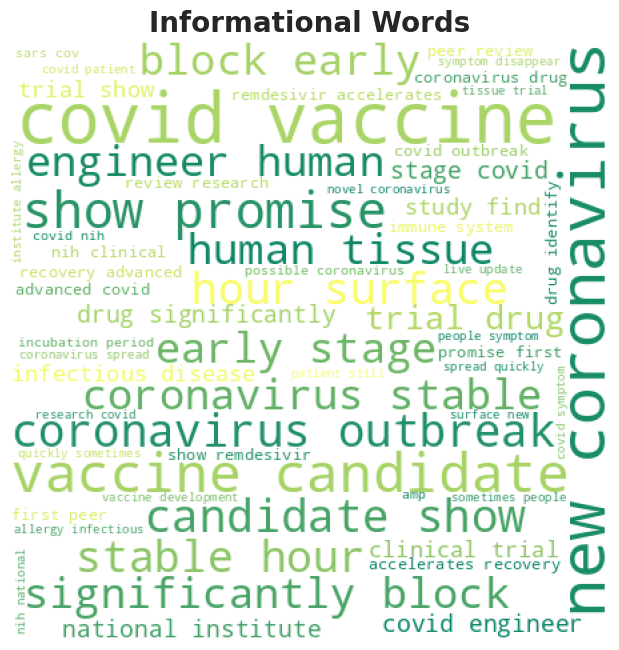

In [27]:
from wordcloud import WordCloud

text = ' '.join(list(truenewsdf['processed_tweet'])) # get list of all words in the truenewsdf dataset

wordcloud = WordCloud(width=450, height=450, background_color='white', min_font_size=8, colormap='summer').generate(text) # create wordcloud using words from tweets labeled as 'true news'

plt.figure(figsize=(6,6), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Informational Words', size='20', fontweight='bold')

plt.show()

Creating a word cloud using only those tweets identified as misinformation.

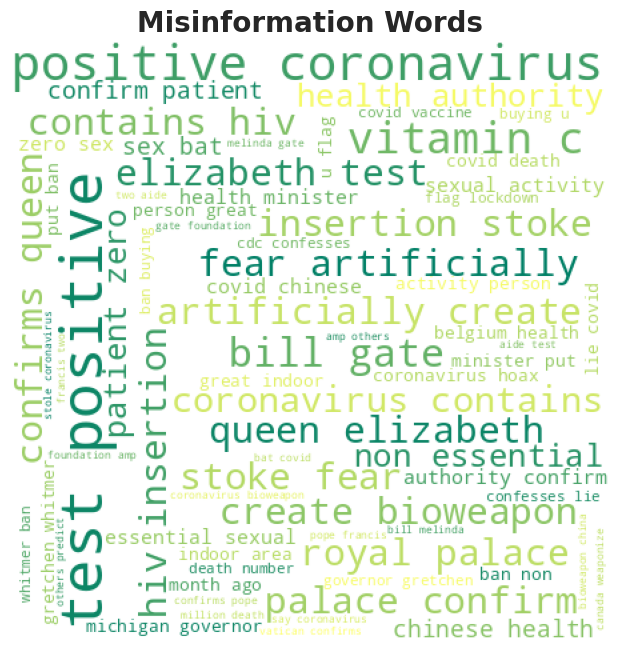

In [28]:
text = ' '.join(list(fakenewsdf['processed_tweet'])) # get list of all words in the fakenewsdf dataset

wordcloud = WordCloud(width=450, height=450, background_color='white', min_font_size=8, colormap='summer').generate(text) # create wordcloud using words from tweets labeled as 'fake news'

plt.figure(figsize=(6,6), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Misinformation Words', size='20', fontweight='bold')

plt.show()

### Sentiment Analysis

**Textblob** sentiment analyzer returns two properties for a given input sentence:


*   Polarity is a float that lies between [-1,1], -1 indicates negative sentiment and +1 indicates positive sentiments.

*   Subjectivity is also a float which lies in the range of [0,1]. Subjective sentences generally refer to personal opinion, emotion, or judgment.

Textblob uses a lexicon-based approach to determine the sentiment of text.

**Source:** https://textblob.readthedocs.io/en/dev/




In [29]:
from textblob import TextBlob

print("Running Sentiment Analysis")

# for loop to get sentiment of text. can be built as function as well.
for row in tweetdf.itertuples():
    tweet = tweetdf.at[row[0], "processed_tweet"]

    analysis = TextBlob(tweet) # applies the TextBlob function to each tweet in the dataset

    tweetdf.at[row[0], "Polarity"] = analysis.sentiment[0] # gets the 'Polarity' score from the TextBlob function output
    tweetdf.at[row[0], "Subjectivity"] = analysis.sentiment[1] # gets the 'Subjectivity' score from the TextBlob function output

    # the following uses the 'Polarity' score to identify if the tweet is 'Positive', 'Negative' or 'Neutral' and assigns that classification to the tweet
    if analysis.sentiment[0] > 0:
        tweetdf.at[row[0], "Sentiment"] = "Positive"
    elif analysis.sentiment[0] < 0:
        tweetdf.at[row[0], "Sentiment"] = "Negative"
    else:
        tweetdf.at[row[0], "Sentiment"] = "Neutral"

Running Sentiment Analysis


In [30]:
tweetdf = tweetdf[['tweet', 'cleaned_tweet', 'processed_tweet', 'Polarity', 'Subjectivity', 'Sentiment', 'tweet_class']] # this is used to arrange the columns as wanted
tweetdf.head()

,tweet,cleaned_tweet,processed_tweet,Polarity,Subjectivity,Sentiment,tweet_class
0,"Ian Haydon, who is participating in a vaccine ...",ian haydon participating vaccine trial coronav...,ian haydon participate vaccine trial coronavir...,0.103333,0.396667,Positive,misinformation
1,Gachibowli Sports Tower turns Covid hospital\n...,gachibowli sports tower turns covid hospital s...,gachibowli sport tower turn covid hospital sto...,-0.166667,0.166667,Negative,misinformation
2,"Protesters at state Capitol are chanting ""Wher...",protesters state capitol chanting flag pointin...,protester state capitol chant flag point capit...,0.400000,0.450000,Positive,misinformation
4,1/2\n\n@WHO recently published a summary of tr...,recently published summary transmission incl s...,recently publish summary transmission incl sym...,0.000000,0.250000,Neutral,misinformation
5,2/2 ... on transmission from asymptomatic indi...,transmission asymptomatic individuals difficul...,transmission asymptomatic individual difficult...,-0.044444,0.544444,Negative,misinformation


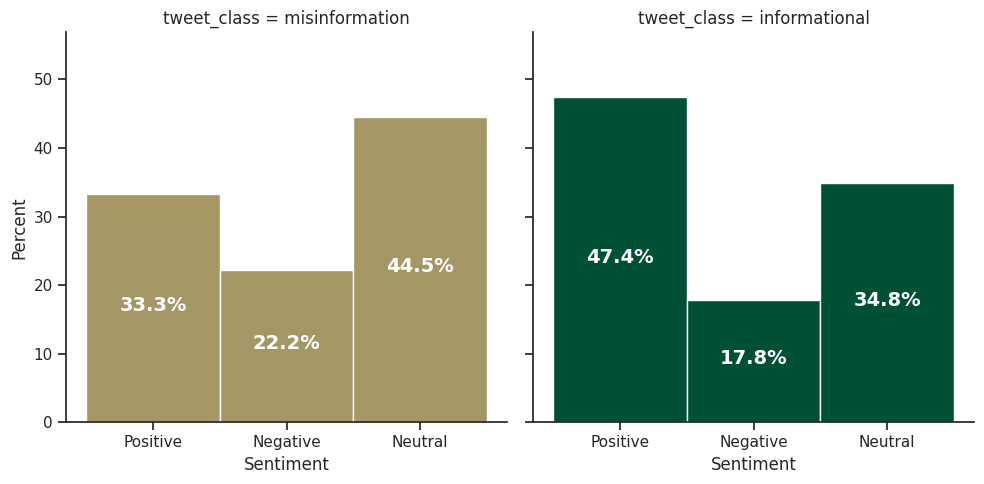

In [31]:
p1 = sns.displot(tweetdf, x="Sentiment", col="tweet_class", col_wrap=2, stat='percent', hue="tweet_class", legend=False, common_norm=False, palette=pal, alpha=1)

for ax in p1.axes.ravel():
    # add percentage labels to displots
    for c in ax.containers:
        labels = [f'{w:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='center', fontsize=14, padding=2, color='white', weight='bold') # add labels to plot and format those labels
    ax.margins(y=0.2) # set the axis margins

plt.tight_layout()
plt.show()

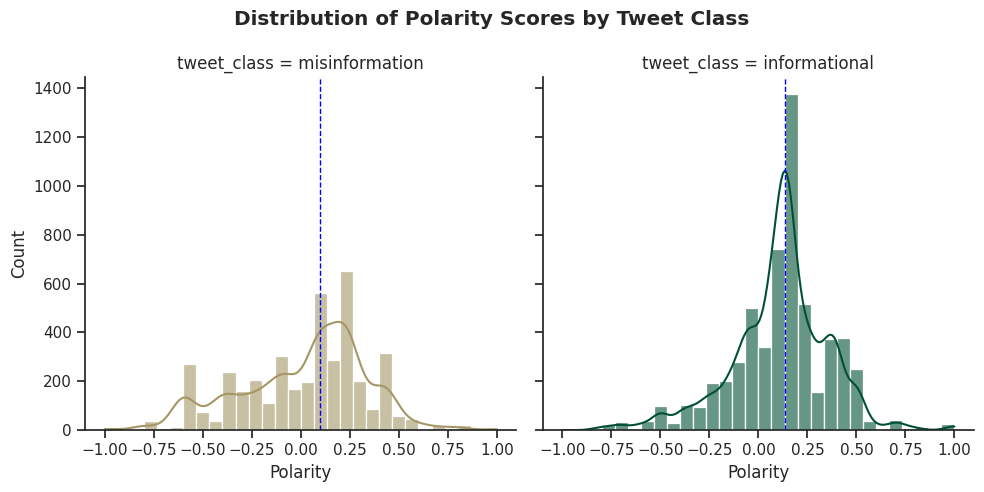

In [32]:
# create distribution plot of 'Polarity' scores by 'tweet_class'
p3 = sns.displot(data=tweetdf[~(tweetdf['Polarity'] == 0)],
        x='Polarity',
        col='tweet_class',
        col_wrap=2,
        hue='tweet_class',
        legend=False,
        palette=pal,
        kde=True,
        bins=30,
        alpha=0.6)

# add title to the plot
p3.fig.suptitle("Distribution of Polarity Scores by Tweet Class", fontweight='bold')

# add line on axis of each plot to show the median 'Polarity' score for each class
for (row, col, hue_idx), data in p3.facet_data():
    if not data.values.size:
        continue
    ax = p3.facet_axis(row, col)
    ax.axvline(data['Polarity'].median(), c="blue", ls="--", lw=1.0)

plt.tight_layout()
plt.show()

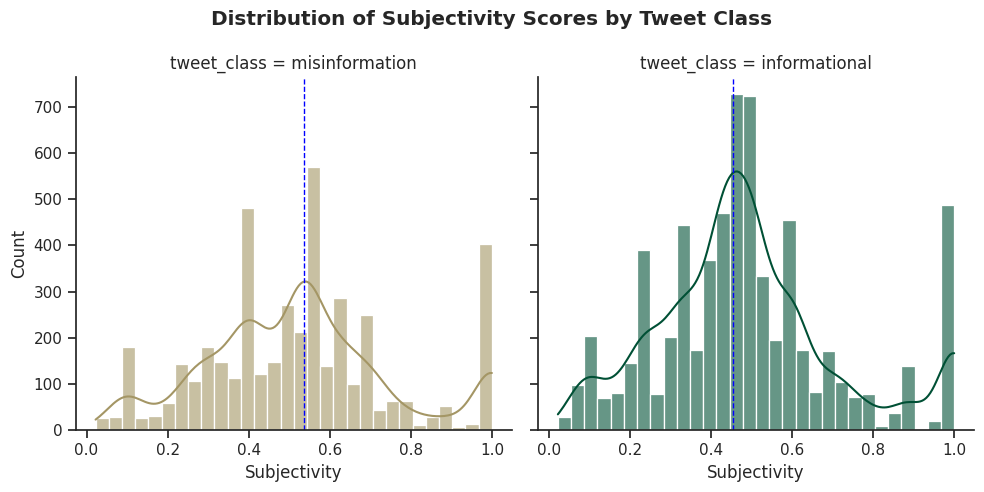

In [33]:
# create distribution plot of 'Subjectivity' scores by 'tweet_class'
p2 = sns.displot(data=tweetdf[~(tweetdf['Subjectivity'] == 0)],
        x='Subjectivity',
        col='tweet_class',
        col_wrap=2,
        hue='tweet_class',
        legend=False,
        palette=pal,
        kde=True,
        bins=30,
        alpha=0.6)

# add title to the plot
p2.fig.suptitle("Distribution of Subjectivity Scores by Tweet Class", fontweight='bold')

# add line on axis of each plot to show the median 'Subjectivity' score for each class
for (row, col, hue_idx), data in p2.facet_data():
    if not data.values.size:
        continue
    ax = p2.facet_axis(row, col)
    ax.axvline(data['Subjectivity'].median(), c="blue", ls="--", lw=1.0)

plt.tight_layout()
plt.show()

### Part-of-Speech Tagging

In [36]:
nltk.download('tagsets')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# define function to identify the parts of speech for each word within each tweet
def pos_func(text):
    word_list = nltk.word_tokenize(text)
    pos_tagged = nltk.pos_tag(word_list)
    print(pos_tagged)

[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [37]:
# perform POS tagging on one tweet from the dataset
pos_output = pos_func(tweetdf['processed_tweet'][30])
pos_output

[('spain', 'NN'), ('doctor', 'NN'), ('brought', 'VBD'), ('guitar', 'JJ'), ('hospital', 'NN'), ('think', 'NN'), ('would', 'MD'), ('sing', 'VB'), ('raise', 'VB'), ('everyone', 'NN'), ('spirit', 'JJ'), ('something', 'NN'), ('unexpected', 'JJ'), ('happen', 'JJ'), ('everyone', 'NN'), ('start', 'NN'), ('sing', 'NN'), ('chill', 'NN')]


The following is an overview of all the available part-of-speech tags.

In [38]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

### Topic Modeling

In [39]:
# import gensim for topic modeling
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Phrases

# define function to preprocess text
def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence)))

all_words = list(sent_to_words(data['processed_tweet']))
fake_words = list(sent_to_words(fakenewsdf['processed_tweet']))
true_words = list(sent_to_words(truenewsdf['processed_tweet']))

print(all_words[:1])

[['get', 'little', 'exercise', 'morning']]


In [40]:
# set input text
text = fake_words

# generate bigrams
bigram = Phrases(text, min_count=1, threshold=1)  # You can adjust the parameters based on your needs.
bigram_mod = gensim.models.phrases.Phraser(bigram)
bigram_text = [bigram_mod[doc] for doc in text]

In [41]:
# set input text
input_text = bigram_text

# Create Dictionary
id2word = corpora.Dictionary(input_text)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in input_text]

In [42]:
lda_model = gensim.models.ldamodel.LdaModel(corpus,
                                            num_topics=10,
                                            id2word=id2word,
                                            passes=15)

In [43]:
# View the topics
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.085*"coronavirus" + 0.030*"test_positive" + 0.026*"pope_francis" + 0.026*"two_aide" + 0.026*"vatican_confirms" + 0.018*"case" + 0.018*"origin" + 0.015*"cdc_recommends" + 0.015*"men_shave" + 0.015*"beard_protect"
Topic: 1 
Words: 0.043*"bill_gate" + 0.039*"permanently_alter" + 0.039*"explains_covid" + 0.039*"experimental_technology" + 0.037*"dna" + 0.027*"say" + 0.022*"origin_ccp" + 0.022*"exclusive_documentary" + 0.022*"program_alert" + 0.022*"virus_premiere"
Topic: 2 
Words: 0.060*"hiv_insertion" + 0.059*"coronavirus_contains" + 0.059*"artificially_create" + 0.059*"stoke_fear" + 0.037*"hedge" + 0.037*"bioweapon_zero" + 0.028*"bioweapon" + 0.017*"stop_test" + 0.016*"right_case" + 0.015*"main_street"
Topic: 3 
Words: 0.048*"vaccine_use" + 0.029*"lie_covid" + 0.029*"death_number" + 0.029*"cdc_confesses" + 0.028*"gate_foundation" + 0.027*"bill_melinda" + 0.026*"amp_others" + 0.026*"predict_million" + 0.025*"simulation_ran" + 0.021*"cdc_say"
Topic: 4 
Words: 0.040*"covid

## **Exploring the Use of Zero-Shot Classification for Text Annotation**

Zero-shot text classification is a task in natural language processing where a model is trained on a set of labeled examples but is then able to classify new examples from previously unseen classes.

Source: https://huggingface.co/tasks/zero-shot-classification

In [ ]:
!pip install transformers

# transformers package supported by Hugging Face (https://huggingface.co/docs/transformers/index)
from transformers import pipeline

In [ ]:
# use pipeline to download zero-shot classifier model from Hugging Face
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

In [ ]:
# set candidate labels
intent_labels = ["question information",
                 "provide information",
                 "suggest a political motive",
                 "promote alternative",
                 "promote prevention",
                 "provide support"]

# set hypothesis template for the zero-shot model
hypothesis_template = "The intent of this tweet is to {}."

# example of tweet to use with the classifier
text = "The NY Times exposes real reason behind coronavirus hype: Crash the market to harm Trump's reelection chances"

# classifier that predicts which candidate label should be applied to the input text
result = classifier(text, intent_labels, hypothesis_template=hypothesis_template, multi_label=True)
print(f"Input: {text}")
print(f"Labels: {result['labels']}\nScores: {result['scores']}")

Input: The NY Times exposes real reason behind coronavirus hype: Crash the market to harm Trump's reelection chances
Labels: ['suggest a political motive', 'provide information', 'question information', 'promote alternative', 'promote prevention', 'provide support']
Scores: [0.9970935583114624, 0.9675841927528381, 0.9379172325134277, 0.03487778827548027, 0.01034717820584774, 0.0008001375827006996]


## **Additional Resource for R Users**

The following is a great resource for R users to learn "Text Mining with R":

https://www.tidytextmining.com/index.html

## **Data Sources**

1. Cui, L., & Lee, D. (2020). CoAID: COVID-19 Healthcare Misinformation Dataset. Retrieved from http://arxiv.org/abs/2006.00885
2. Memon, S. A., & Carley, K. M. (2020). Characterizing COVID-19 misinformation communities using a novel Twitter dataset. Retrieved from http://arxiv.org/abs/2008.00791
3. Shahi, G. K., Dirkson, A., & Majchrzak, T. A. (2021). An exploratory study of COVID-19 misinformation on Twitter. Online Social Networks and Media, 22(100104), 100104. doi:10.1016/j.osnem.2020.100104